In [1]:
from keras.layers import Input, Dense, GaussianNoise, Lambda, Dropout, concatenate, LSTM, Add, Multiply, Layer
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
import numpy as np
import keras
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.utils import plot_model
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from utils import *
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.


In [2]:
H = K.constant([[1, 1]])
SNR1 = 7
SNR2 = 7
SNRs = [SNR1, SNR2]
ebno = [calc_ebno(SNR) for SNR in SNRs]

k = 2
n_channel = 2
M = 2 ** k
k = int(k)
R = k / n_channel

In [23]:
input_signal1 = Input(shape=(M,), name="input1")
input_signal2 = Input(shape=(M,), name="input2")
encoder1 = Sequential([
    Dense(M, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="encoder1")
encoder2 = Sequential([
    Dense(M, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="encoder2")

combiner = Sequential([
    Dense(n_channel, activation="relu"),
    Dense(n_channel, activation="linear"),
    BatchNormalization(center=False, scale=False),
], name="combiner")

signal_input1 = Sequential(
    [Lambda(TransmissionLayer, arguments={"t":0, "k":0}),
    GaussianNoise(np.sqrt(1 / (2 * R * ebno[0])))], name="transmit1"
)

signal_input2 = Sequential(
    [Lambda(TransmissionLayer, arguments={"t":0, "k":1}),
    GaussianNoise(np.sqrt(1 / (2 * R * ebno[1])))], name="transmit2")

decoder1 = Sequential([
    Dense(M, activation="relu"),
    Dense(M, activation="relu"),
    Dense(M, activation="softmax")
], name="decoder1")

decoder2 = Sequential([
    Dense(M, activation="relu"),
    Dense(M, activation="relu"),
    Dense(M, activation="softmax")
], name="decoder2")

In [12]:
x1 = encoder1(input_signal1)
x2 = encoder2(input_signal2)
x = concatenate([x1, x2], axis=1)
x = combiner(x)
x1 = signal_input1(x)
x2 = signal_input2(x)
out1 = decoder1(x1)
out2 = decoder2(x2)

model = Model(inputs=[input_signal1, input_signal2], outputs=[out1, out2])
model.summary()
alpha = K.variable(.5)

model.compile(optimizer="adam", loss=["categorical_crossentropy", "categorical_crossentropy"],
            loss_weights=[alpha, (1 - alpha)], metrics=["accuracy", BER])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
encoder1 (Sequential)           (None, 2)            30          input1[0][0]                     
__________________________________________________________________________________________________
encoder2 (Sequential)           (None, 2)            30          input2[0][0]                     
____________________________________________________________________________________________

In [15]:
train_datas = generate_train_datas()

model.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="loss", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    AlphaCallback(alpha)
])

Train on 200000 samples, validate on 200000 samples
Epoch 1/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2873 - decoder2_loss: 0.2862 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0265 - val_decoder1_loss: 0.0266 - val_decoder2_loss: 0.0265 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 2/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2876 - decoder2_loss: 0.2851 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0262 - val_decoder1_loss: 0.0256 - val_decoder2_loss: 0.0268 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 3/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.

200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2852 - decoder2_loss: 0.2856 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0268 - val_decoder1_loss: 0.0269 - val_decoder2_loss: 0.0267 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 40/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2875 - decoder2_loss: 0.2847 - decoder1_acc: 0.8835 - decoder1_BER: 0.0582 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0272 - val_decoder1_loss: 0.0272 - val_decoder2_loss: 0.0272 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 41/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2859 - decoder2_loss: 0.2863 - decoder1_acc: 0.8834 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2856 - decoder2_loss: 0.2866 - decoder1_acc: 0.8841 - decoder1_BER: 0.0580 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.0279 - val_decoder1_loss: 0.0282 - val_decoder2_loss: 0.0276 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 78/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2854 - decoder2_loss: 0.2864 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8830 - decoder2_BER: 0.0585 - val_loss: 0.0278 - val_decoder1_loss: 0.0280 - val_decoder2_loss: 0.0277 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 79/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2874 - decoder2_loss: 0.2862 - decoder1_acc: 0.8822 - decoder1_

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2886 - decoder2_loss: 0.2851 - decoder1_acc: 0.8820 - decoder1_BER: 0.0590 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0282 - val_decoder1_loss: 0.0281 - val_decoder2_loss: 0.0284 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 116/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2855 - decoder2_loss: 0.2867 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8831 - decoder2_BER: 0.0584 - val_loss: 0.0281 - val_decoder1_loss: 0.0283 - val_decoder2_loss: 0.0279 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 117/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2878 - decoder1_loss: 0.2882 - decoder2_loss: 0.2874 - decoder1_acc: 0.8829 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2871 - decoder1_loss: 0.2856 - decoder2_loss: 0.2886 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.0285 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 154/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2880 - decoder2_loss: 0.2852 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0284 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0283 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 155/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2875 - decoder1_loss: 0.2884 - decoder2_loss: 0.2866 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2848 - decoder1_loss: 0.2847 - decoder2_loss: 0.2850 - decoder1_acc: 0.8833 - decoder1_BER: 0.0584 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0285 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 192/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2858 - decoder1_loss: 0.2869 - decoder2_loss: 0.2846 - decoder1_acc: 0.8823 - decoder1_BER: 0.0588 - decoder2_acc: 0.8841 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 193/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2877 - decoder2_loss: 0.2862 - decoder1_acc: 0.8832 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2858 - decoder2_loss: 0.2862 - decoder1_acc: 0.8835 - decoder1_BER: 0.0583 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0287 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 230/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2873 - decoder2_loss: 0.2866 - decoder1_acc: 0.8832 - decoder1_BER: 0.0584 - decoder2_acc: 0.8828 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 231/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2868 - decoder2_loss: 0.2864 - decoder1_acc: 0.8832 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2861 - decoder2_loss: 0.2862 - decoder1_acc: 0.8829 - decoder1_BER: 0.0585 - decoder2_acc: 0.8826 - decoder2_BER: 0.0587 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 268/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2862 - decoder2_loss: 0.2861 - decoder1_acc: 0.8831 - decoder1_BER: 0.0585 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 269/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2865 - decoder1_loss: 0.2869 - decoder2_loss: 0.2861 - decoder1_acc: 0.8825 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2872 - decoder1_loss: 0.2874 - decoder2_loss: 0.2871 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8820 - decoder2_BER: 0.0590 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 306/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2847 - decoder2_loss: 0.2855 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 307/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2865 - decoder2_loss: 0.2854 - decoder1_acc: 0.8831 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2884 - decoder2_loss: 0.2832 - decoder1_acc: 0.8821 - decoder1_BER: 0.0590 - decoder2_acc: 0.8848 - decoder2_BER: 0.0576 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 344/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2864 - decoder1_loss: 0.2867 - decoder2_loss: 0.2861 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 345/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2877 - decoder2_loss: 0.2856 - decoder1_acc: 0.8822 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2848 - decoder1_loss: 0.2851 - decoder2_loss: 0.2845 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8840 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 382/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2877 - decoder2_loss: 0.2849 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8835 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 383/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2872 - decoder1_loss: 0.2880 - decoder2_loss: 0.2864 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2867 - decoder2_loss: 0.2864 - decoder1_acc: 0.8827 - decoder1_BER: 0.0587 - decoder2_acc: 0.8839 - decoder2_BER: 0.0581 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 420/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2876 - decoder2_loss: 0.2864 - decoder1_acc: 0.8833 - decoder1_BER: 0.0583 - decoder2_acc: 0.8837 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 421/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2877 - decoder1_loss: 0.2869 - decoder2_loss: 0.2885 - decoder1_acc: 0.8826 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2864 - decoder2_loss: 0.2854 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 458/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2874 - decoder2_loss: 0.2849 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8842 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 459/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2853 - decoder2_loss: 0.2870 - decoder1_acc: 0.8833 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2850 - decoder1_loss: 0.2864 - decoder2_loss: 0.2837 - decoder1_acc: 0.8832 - decoder1_BER: 0.0584 - decoder2_acc: 0.8846 - decoder2_BER: 0.0577 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 496/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2865 - decoder2_loss: 0.2857 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 497/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2852 - decoder1_loss: 0.2860 - decoder2_loss: 0.2843 - decoder1_acc: 0.8825 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2855 - decoder1_loss: 0.2872 - decoder2_loss: 0.2837 - decoder1_acc: 0.8823 - decoder1_BER: 0.0588 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 534/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2863 - decoder2_loss: 0.2871 - decoder1_acc: 0.8835 - decoder1_BER: 0.0583 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 535/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2848 - decoder2_loss: 0.2863 - decoder1_acc: 0.8834 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2872 - decoder2_loss: 0.2864 - decoder1_acc: 0.8827 - decoder1_BER: 0.0586 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 572/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2834 - decoder2_loss: 0.2884 - decoder1_acc: 0.8846 - decoder1_BER: 0.0577 - decoder2_acc: 0.8825 - decoder2_BER: 0.0588 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 573/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2866 - decoder2_loss: 0.2859 - decoder1_acc: 0.8830 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2843 - decoder2_loss: 0.2883 - decoder1_acc: 0.8842 - decoder1_BER: 0.0579 - decoder2_acc: 0.8826 - decoder2_BER: 0.0587 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 610/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2858 - decoder2_loss: 0.2850 - decoder1_acc: 0.8829 - decoder1_BER: 0.0586 - decoder2_acc: 0.8835 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 611/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2879 - decoder2_loss: 0.2853 - decoder1_acc: 0.8821 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2849 - decoder2_loss: 0.2854 - decoder1_acc: 0.8841 - decoder1_BER: 0.0580 - decoder2_acc: 0.8838 - decoder2_BER: 0.0581 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 648/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2863 - decoder2_loss: 0.2863 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8829 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 649/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2861 - decoder1_loss: 0.2860 - decoder2_loss: 0.2863 - decoder1_acc: 0.8838 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2851 - decoder1_loss: 0.2867 - decoder2_loss: 0.2835 - decoder1_acc: 0.8829 - decoder1_BER: 0.0585 - decoder2_acc: 0.8836 - decoder2_BER: 0.0582 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 686/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2850 - decoder1_loss: 0.2843 - decoder2_loss: 0.2857 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8834 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 687/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2875 - decoder1_loss: 0.2882 - decoder2_loss: 0.2867 - decoder1_acc: 0.8822 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2857 - decoder1_loss: 0.2848 - decoder2_loss: 0.2867 - decoder1_acc: 0.8837 - decoder1_BER: 0.0581 - decoder2_acc: 0.8831 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 724/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2856 - decoder2_loss: 0.2870 - decoder1_acc: 0.8835 - decoder1_BER: 0.0582 - decoder2_acc: 0.8833 - decoder2_BER: 0.0583 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 725/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2844 - decoder2_loss: 0.2876 - decoder1_acc: 0.8839 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2856 - decoder2_loss: 0.2856 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 762/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2844 - decoder1_loss: 0.2836 - decoder2_loss: 0.2851 - decoder1_acc: 0.8850 - decoder1_BER: 0.0575 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 763/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2862 - decoder1_loss: 0.2860 - decoder2_loss: 0.2865 - decoder1_acc: 0.8835 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2859 - decoder1_loss: 0.2868 - decoder2_loss: 0.2850 - decoder1_acc: 0.8825 - decoder1_BER: 0.0587 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 800/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2862 - decoder2_loss: 0.2874 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8827 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 801/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2856 - decoder1_loss: 0.2850 - decoder2_loss: 0.2861 - decoder1_acc: 0.8838 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2866 - decoder1_loss: 0.2852 - decoder2_loss: 0.2880 - decoder1_acc: 0.8837 - decoder1_BER: 0.0581 - decoder2_acc: 0.8827 - decoder2_BER: 0.0586 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 838/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2854 - decoder1_loss: 0.2851 - decoder2_loss: 0.2857 - decoder1_acc: 0.8840 - decoder1_BER: 0.0580 - decoder2_acc: 0.8839 - decoder2_BER: 0.0580 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 839/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2870 - decoder1_loss: 0.2883 - decoder2_loss: 0.2856 - decoder1_acc: 0.8826 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2874 - decoder2_loss: 0.2852 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8845 - decoder2_BER: 0.0577 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 876/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2857 - decoder1_loss: 0.2872 - decoder2_loss: 0.2843 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8841 - decoder2_BER: 0.0579 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 877/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2869 - decoder1_loss: 0.2872 - decoder2_loss: 0.2866 - decoder1_acc: 0.8829 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2863 - decoder1_loss: 0.2848 - decoder2_loss: 0.2877 - decoder1_acc: 0.8834 - decoder1_BER: 0.0583 - decoder2_acc: 0.8823 - decoder2_BER: 0.0589 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 914/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2881 - decoder1_loss: 0.2893 - decoder2_loss: 0.2869 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8832 - decoder2_BER: 0.0584 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 915/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2867 - decoder1_loss: 0.2879 - decoder2_loss: 0.2855 - decoder1_acc: 0.8823 - decoder

200000/200000 [==============================] - 0s 2us/step - loss: 0.2868 - decoder1_loss: 0.2851 - decoder2_loss: 0.2885 - decoder1_acc: 0.8836 - decoder1_BER: 0.0582 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 952/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2860 - decoder1_loss: 0.2864 - decoder2_loss: 0.2856 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8831 - decoder2_BER: 0.0585 - val_loss: 0.0286 - val_decoder1_loss: 0.0286 - val_decoder2_loss: 0.0286 - val_decoder1_acc: 1.0000 - val_decoder1_BER: 0.0000e+00 - val_decoder2_acc: 1.0000 - val_decoder2_BER: 0.0000e+00
Epoch 953/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2877 - decoder1_loss: 0.2851 - decoder2_loss: 0.2903 - decoder1_acc: 0.8834 - decoder

KeyboardInterrupt: 

# Experiment 2
Train autoencoder first, then train combiner and decoder only

In [3]:
seed_everything(21)
input_signal1 = Input(shape=(M,), name="input1")

encoder1 = create_encoder([M, n_channel], name="encoder1", activations=["relu", "linear"])
signal_input1 = create_inputs(R=R, H=H, t=0, k=0, ebno=ebno, name="transmit1")
decoder1 = create_decoder([M, M, M], name="decoder1", activation="relu")

x1 = encoder1(input_signal1)
x1 = signal_input1(x1)
out1 = decoder1(x1)

model1 = Model(inputs=input_signal1, outputs=out1)

model1.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", BER])

train_datas = generate_train_datas(k=1)

model1.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="BER", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.7, patience=20),
])

bers = ber_curve(encoder1, decoder1, R = R, SNR_range = [-10, 20], M=M)









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 200000 samples, validate on 200000 samples
Epoch 1/2000





200000/200000 [==============================] - 0s 2us/step - loss: 1.2412 - acc: 0.1591 - BER: 0.2520 - val_loss: 1.1909 - val_acc: 0.3004 - val_BER: 0.2515
Epoch 2/2000
200000/200000 [==============================] - 0s 1us/step - loss: 1.1667 - acc: 0.3960 - BER: 0.2511 - val_loss: 1.1299 - val_acc: 0.4889 - val_BER: 0.2508
Epoch 3/2000
200000/200000 [==============================] - 0s 1us/step - loss: 1.1021 - acc: 0.5034 - BER: 0.2504 - val_loss: 1.0697 - val_acc: 0.5728 - val_BER: 0.2487
Epoch 4/2000
200000/200000 [==============================] - 0s 1us/step - loss: 1.0402 - acc: 0.6020 - BER: 0.2407 - val_loss: 1.0142 - val_acc: 0.6562 - val_BER: 0.2348
Epoch 5/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.9834 - acc: 0.6772 - BER: 0.1988 - val_loss: 0.9642 - val_acc: 0.6

Epoch 27/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.2951 - acc: 0.9902 - BER: 0.0639 - val_loss: 0.2903 - val_acc: 0.9813 - val_BER: 0.0662
Epoch 28/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.2756 - acc: 0.9909 - BER: 0.0638 - val_loss: 0.2668 - val_acc: 0.9864 - val_BER: 0.0653
Epoch 29/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.2574 - acc: 0.9920 - BER: 0.0488 - val_loss: 0.2497 - val_acc: 0.9874 - val_BER: 0.0127
Epoch 30/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.2413 - acc: 0.9927 - BER: 0.0116 - val_loss: 0.2290 - val_acc: 0.9908 - val_BER: 0.0092
Epoch 31/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.2262 - acc: 0.9933 - BER: 0.0091 - val_loss: 0.2150 - val_acc: 0.9926 - val_BER: 0.0067
Epoch 32/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.2130 - acc: 0.9940 - BER: 0.0072 - val_loss: 0.202

200000/200000 [==============================] - 0s 1us/step - loss: 0.0454 - acc: 0.9983 - BER: 8.4500e-04 - val_loss: 0.0441 - val_acc: 0.9986 - val_BER: 7.0875e-04
Epoch 74/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0438 - acc: 0.9985 - BER: 7.6875e-04 - val_loss: 0.0430 - val_acc: 0.9984 - val_BER: 7.7875e-04
Epoch 75/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0426 - acc: 0.9983 - BER: 8.2875e-04 - val_loss: 0.0413 - val_acc: 0.9986 - val_BER: 6.9500e-04
Epoch 76/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0414 - acc: 0.9982 - BER: 9.0250e-04 - val_loss: 0.0404 - val_acc: 0.9983 - val_BER: 8.4125e-04
Epoch 77/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0400 - acc: 0.9982 - BER: 8.8125e-04 - val_loss: 0.0389 - val_acc: 0.9984 - val_BER: 7.8375e-04
Epoch 78/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0385 - acc: 0.9984 - BER

200000/200000 [==============================] - 0s 1us/step - loss: 0.0127 - acc: 0.9982 - BER: 9.2125e-04 - val_loss: 0.0115 - val_acc: 0.9984 - val_BER: 7.9000e-04
Epoch 119/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0120 - acc: 0.9983 - BER: 8.5375e-04 - val_loss: 0.0115 - val_acc: 0.9984 - val_BER: 7.9625e-04
Epoch 120/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0113 - acc: 0.9984 - BER: 7.8750e-04 - val_loss: 0.0108 - val_acc: 0.9986 - val_BER: 7.1000e-04
Epoch 121/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0115 - acc: 0.9983 - BER: 8.7250e-04 - val_loss: 0.0108 - val_acc: 0.9984 - val_BER: 7.8125e-04
Epoch 122/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0107 - acc: 0.9985 - BER: 7.5750e-04 - val_loss: 0.0104 - val_acc: 0.9986 - val_BER: 6.8750e-04
Epoch 123/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0106 - acc: 0.9985 

200000/200000 [==============================] - 0s 1us/step - loss: 0.0060 - acc: 0.9984 - BER: 8.0500e-04 - val_loss: 0.0058 - val_acc: 0.9985 - val_BER: 7.6125e-04
Epoch 164/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0062 - acc: 0.9983 - BER: 8.3625e-04 - val_loss: 0.0050 - val_acc: 0.9987 - val_BER: 6.3375e-04
Epoch 165/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0057 - acc: 0.9984 - BER: 7.9750e-04 - val_loss: 0.0054 - val_acc: 0.9985 - val_BER: 7.3625e-04
Epoch 166/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0057 - acc: 0.9985 - BER: 7.4750e-04 - val_loss: 0.0056 - val_acc: 0.9985 - val_BER: 7.6500e-04
Epoch 167/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0055 - acc: 0.9985 - BER: 7.6375e-04 - val_loss: 0.0055 - val_acc: 0.9986 - val_BER: 7.0875e-04
Epoch 168/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0057 - acc: 0.9983 

200000/200000 [==============================] - 0s 1us/step - loss: 0.0052 - acc: 0.9984 - BER: 7.9500e-04 - val_loss: 0.0048 - val_acc: 0.9985 - val_BER: 7.7000e-04
Epoch 209/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0046 - acc: 0.9985 - BER: 7.2625e-04 - val_loss: 0.0048 - val_acc: 0.9984 - val_BER: 7.8500e-04
Epoch 210/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0049 - acc: 0.9984 - BER: 8.0750e-04 - val_loss: 0.0048 - val_acc: 0.9985 - val_BER: 7.3750e-04
Epoch 211/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0051 - acc: 0.9984 - BER: 7.9500e-04 - val_loss: 0.0049 - val_acc: 0.9985 - val_BER: 7.4250e-04
Epoch 212/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0048 - acc: 0.9985 - BER: 7.4000e-04 - val_loss: 0.0046 - val_acc: 0.9986 - val_BER: 7.2000e-04
Epoch 213/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0048 - acc: 0.9985 

200000/200000 [==============================] - 0s 1us/step - loss: 0.0050 - acc: 0.9984 - BER: 8.0000e-04 - val_loss: 0.0047 - val_acc: 0.9985 - val_BER: 7.4125e-04
Epoch 254/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0047 - acc: 0.9985 - BER: 7.5375e-04 - val_loss: 0.0049 - val_acc: 0.9983 - val_BER: 8.2750e-04
Epoch 255/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0046 - acc: 0.9984 - BER: 7.8375e-04 - val_loss: 0.0051 - val_acc: 0.9983 - val_BER: 8.3500e-04
Epoch 256/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0048 - acc: 0.9986 - BER: 7.1625e-04 - val_loss: 0.0045 - val_acc: 0.9985 - val_BER: 7.2875e-04
Epoch 257/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0050 - acc: 0.9983 - BER: 8.3625e-04 - val_loss: 0.0049 - val_acc: 0.9985 - val_BER: 7.6500e-04
Epoch 258/2000
200000/200000 [==============================] - 0s 1us/step - loss: 0.0045 - acc: 0.9986 

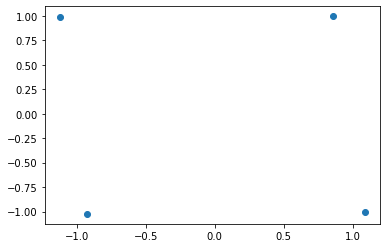

In [4]:
plot_scatter_constellation(encoder1)

In [5]:
encoder1.trainable = False

In [76]:
seed_everything(22)
input_signal2 = Input(shape=(M,), name="input2")
decoder1 = create_decoder([M * 4, M * 2, M], name="decoder1", activation="relu")
decoder2 = create_decoder([M * 4, M * 2, M], name="decoder2", activation="relu")
signal_input2 = create_inputs(R=R, H=H, t=0, k=1, ebno=ebno, name="transmit2")
signal_input1 = create_inputs(R=R, H=H, t=0, k=0, ebno=ebno, name="transmit1")
combiner = create_combiner(layer_sizes=[n_channel * 4, n_channel], activations=["relu", "tanh"], name="combiner")

In [77]:
x1 = encoder1(input_signal1)
x2 = encoder1(input_signal2)
x = concatenate([x1, x2], axis=1)
x = combiner(x)
x1 = signal_input1(x)
x2 = signal_input2(x)
out1 = decoder1(x1)
out2 = decoder2(x2)

model = Model(inputs=[input_signal1, input_signal2], outputs=[out1, out2])
model.summary()
alpha = K.variable(.5)

optim = SGD(momentum=.9)

model.compile(optimizer="rmsprop", loss=["categorical_crossentropy", "categorical_crossentropy"],
            loss_weights=[alpha, (1 - alpha)], metrics=["accuracy", BER])

train_datas = generate_train_datas(k=2)

model.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=40000,
    epochs=2000, callbacks=[
    EarlyStopping(patience=100, restore_best_weights=True, monitor="loss", mode="min"),
    ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    AlphaCallback(alpha),
])

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
encoder1 (Sequential)           (None, 2)            34          input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 4)            0           encoder1[40][0]           

C:\Users\Furkan\miniconda3\envs\commtf\lib\site-packages\keras\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.391000). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200000/200000 [==============================] - 4s 20us/step - loss: 1.4602 - decoder1_loss: 1.3497 - decoder2_loss: 1.5587 - decoder1_acc: 0.3634 - decoder1_BER: 0.2500 - decoder2_acc: 0.1519 - decoder2_BER: 0.2500 - val_loss: 1.4290 - val_decoder1_loss: 1.3288 - val_decoder2_loss: 1.5165 - val_decoder1_acc: 0.3756 - val_decoder1_BER: 0.2500 - val_decoder2_acc: 0.2101 - val_decoder2_BER: 0.2500
Epoch 2/2000
200000/200000 [==============================] - 1s 3us/step - loss: 1.4127 - decoder1_loss: 1.3198 - decoder2_loss: 1.4945 - decoder1_acc: 0.4123 - decoder1_BER: 0.2500 - decoder2_acc: 0.2810 - decoder2_BER: 0.2500 - val_loss: 1.3913 - val_decoder1_loss: 1.3063 - val_decoder2_loss: 1.4669 - val_decoder1_acc: 0.4587 - val_decoder1_BER: 0.2500 - val_decoder2_acc: 0.3731 - val_decoder2_BER: 0.2500
Epoch 3/2000
200000/200000 [==============================] - 1s 3us/step - loss: 1.3782 - decoder1_loss: 1.2987 - decoder2_loss: 1.4493 - decoder1_acc: 0.4635 - decoder1_BER: 0.2500 - dec

Epoch 21/2000
200000/200000 [==============================] - 0s 2us/step - loss: 1.0000 - decoder1_loss: 1.0097 - decoder2_loss: 0.9900 - decoder1_acc: 0.5504 - decoder1_BER: 0.1903 - decoder2_acc: 0.5259 - decoder2_BER: 0.2102 - val_loss: 0.9984 - val_decoder1_loss: 1.0052 - val_decoder2_loss: 0.9915 - val_decoder1_acc: 0.5487 - val_decoder1_BER: 0.1890 - val_decoder2_acc: 0.5245 - val_decoder2_BER: 0.2107
Epoch 22/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.9854 - decoder1_loss: 0.9955 - decoder2_loss: 0.9751 - decoder1_acc: 0.5529 - decoder1_BER: 0.1848 - decoder2_acc: 0.5313 - decoder2_BER: 0.2100 - val_loss: 0.9842 - val_decoder1_loss: 0.9905 - val_decoder2_loss: 0.9779 - val_decoder1_acc: 0.5552 - val_decoder1_BER: 0.1842 - val_decoder2_acc: 0.5275 - val_decoder2_BER: 0.2105
Epoch 23/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.9707 - decoder1_loss: 0.9810 - decoder2_loss: 0.9602 - decoder1_acc: 0.5562 - decoder1_BE

Epoch 41/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.7269 - decoder1_loss: 0.6745 - decoder2_loss: 0.7728 - decoder1_acc: 0.7669 - decoder1_BER: 0.1281 - decoder2_acc: 0.5646 - decoder2_BER: 0.2082 - val_loss: 0.7536 - val_decoder1_loss: 0.7102 - val_decoder2_loss: 0.7910 - val_decoder1_acc: 0.7739 - val_decoder1_BER: 0.1197 - val_decoder2_acc: 0.5526 - val_decoder2_BER: 0.2105
Epoch 42/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.7160 - decoder1_loss: 0.6598 - decoder2_loss: 0.7645 - decoder1_acc: 0.7731 - decoder1_BER: 0.1233 - decoder2_acc: 0.5699 - decoder2_BER: 0.2083 - val_loss: 0.7415 - val_decoder1_loss: 0.6920 - val_decoder2_loss: 0.7843 - val_decoder1_acc: 0.7822 - val_decoder1_BER: 0.1146 - val_decoder2_acc: 0.5580 - val_decoder2_BER: 0.2109
Epoch 43/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.7054 - decoder1_loss: 0.6443 - decoder2_loss: 0.7576 - decoder1_acc: 0.7833 - decoder1_BE

Epoch 61/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.5475 - decoder1_loss: 0.4368 - decoder2_loss: 0.6252 - decoder1_acc: 0.8717 - decoder1_BER: 0.0773 - decoder2_acc: 0.6703 - decoder2_BER: 0.1686 - val_loss: 0.5967 - val_decoder1_loss: 0.4889 - val_decoder2_loss: 0.6715 - val_decoder1_acc: 0.8258 - val_decoder1_BER: 0.0953 - val_decoder2_acc: 0.6127 - val_decoder2_BER: 0.1931
Epoch 62/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.5405 - decoder1_loss: 0.4288 - decoder2_loss: 0.6180 - decoder1_acc: 0.8714 - decoder1_BER: 0.0755 - decoder2_acc: 0.6756 - decoder2_BER: 0.1645 - val_loss: 0.5956 - val_decoder1_loss: 0.4826 - val_decoder2_loss: 0.6738 - val_decoder1_acc: 0.8257 - val_decoder1_BER: 0.0929 - val_decoder2_acc: 0.6075 - val_decoder2_BER: 0.1951
Epoch 63/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.5338 - decoder1_loss: 0.4212 - decoder2_loss: 0.6114 - decoder1_acc: 0.8742 - decoder1_BE

Epoch 81/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.4375 - decoder1_loss: 0.3279 - decoder2_loss: 0.5081 - decoder1_acc: 0.8783 - decoder1_BER: 0.0611 - decoder2_acc: 0.7072 - decoder2_BER: 0.1441 - val_loss: 0.5165 - val_decoder1_loss: 0.3753 - val_decoder2_loss: 0.6069 - val_decoder1_acc: 0.8469 - val_decoder1_BER: 0.0765 - val_decoder2_acc: 0.6544 - val_decoder2_BER: 0.1688
Epoch 82/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.4341 - decoder1_loss: 0.3242 - decoder2_loss: 0.5045 - decoder1_acc: 0.8786 - decoder1_BER: 0.0610 - decoder2_acc: 0.7078 - decoder2_BER: 0.1439 - val_loss: 0.5163 - val_decoder1_loss: 0.3727 - val_decoder2_loss: 0.6095 - val_decoder1_acc: 0.8484 - val_decoder1_BER: 0.0758 - val_decoder2_acc: 0.6553 - val_decoder2_BER: 0.1679
Epoch 83/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.4303 - decoder1_loss: 0.3214 - decoder2_loss: 0.5002 - decoder1_acc: 0.8797 - decoder1_BE

Epoch 101/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3890 - decoder1_loss: 0.2933 - decoder2_loss: 0.4515 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.7544 - decoder2_BER: 0.1236 - val_loss: 0.4848 - val_decoder1_loss: 0.3579 - val_decoder2_loss: 0.5654 - val_decoder1_acc: 0.8467 - val_decoder1_BER: 0.0766 - val_decoder2_acc: 0.7147 - val_decoder2_BER: 0.1449
Epoch 102/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3876 - decoder1_loss: 0.2944 - decoder2_loss: 0.4480 - decoder1_acc: 0.8821 - decoder1_BER: 0.0589 - decoder2_acc: 0.7605 - decoder2_BER: 0.1212 - val_loss: 0.4845 - val_decoder1_loss: 0.3560 - val_decoder2_loss: 0.5716 - val_decoder1_acc: 0.8471 - val_decoder1_BER: 0.0764 - val_decoder2_acc: 0.7185 - val_decoder2_BER: 0.1433
Epoch 103/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3867 - decoder1_loss: 0.2951 - decoder2_loss: 0.4474 - decoder1_acc: 0.8814 - decoder1

Epoch 121/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.3407 - decoder1_loss: 0.2903 - decoder2_loss: 0.3792 - decoder1_acc: 0.8820 - decoder1_BER: 0.0590 - decoder2_acc: 0.8529 - decoder2_BER: 0.0737 - val_loss: 0.4495 - val_decoder1_loss: 0.3561 - val_decoder2_loss: 0.5220 - val_decoder1_acc: 0.8480 - val_decoder1_BER: 0.0760 - val_decoder2_acc: 0.7858 - val_decoder2_BER: 0.1072
Epoch 122/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3353 - decoder1_loss: 0.2900 - decoder2_loss: 0.3706 - decoder1_acc: 0.8816 - decoder1_BER: 0.0592 - decoder2_acc: 0.8573 - decoder2_BER: 0.0714 - val_loss: 0.4524 - val_decoder1_loss: 0.3485 - val_decoder2_loss: 0.5351 - val_decoder1_acc: 0.8511 - val_decoder1_BER: 0.0745 - val_decoder2_acc: 0.7785 - val_decoder2_BER: 0.1110
Epoch 123/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.3351 - decoder1_loss: 0.2901 - decoder2_loss: 0.3706 - decoder1_acc: 0.8816 - decoder1

Epoch 141/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.3025 - decoder1_loss: 0.2872 - decoder2_loss: 0.3166 - decoder1_acc: 0.8827 - decoder1_BER: 0.0586 - decoder2_acc: 0.8747 - decoder2_BER: 0.0627 - val_loss: 0.3267 - val_decoder1_loss: 0.2969 - val_decoder2_loss: 0.3529 - val_decoder1_acc: 0.8768 - val_decoder1_BER: 0.0616 - val_decoder2_acc: 0.8523 - val_decoder2_BER: 0.0738
Epoch 142/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3010 - decoder1_loss: 0.2876 - decoder2_loss: 0.3130 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8756 - decoder2_BER: 0.0622 - val_loss: 0.3187 - val_decoder1_loss: 0.2918 - val_decoder2_loss: 0.3440 - val_decoder1_acc: 0.8795 - val_decoder1_BER: 0.0602 - val_decoder2_acc: 0.8562 - val_decoder2_BER: 0.0720
Epoch 143/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.3012 - decoder1_loss: 0.2868 - decoder2_loss: 0.3144 - decoder1_acc: 0.8827 - decoder1

Epoch 161/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2909 - decoder1_loss: 0.2865 - decoder2_loss: 0.2954 - decoder1_acc: 0.8838 - decoder1_BER: 0.0581 - decoder2_acc: 0.8799 - decoder2_BER: 0.0601 - val_loss: 0.2957 - val_decoder1_loss: 0.2895 - val_decoder2_loss: 0.3015 - val_decoder1_acc: 0.8814 - val_decoder1_BER: 0.0593 - val_decoder2_acc: 0.8768 - val_decoder2_BER: 0.0616
Epoch 162/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2918 - decoder1_loss: 0.2894 - decoder2_loss: 0.2941 - decoder1_acc: 0.8819 - decoder1_BER: 0.0590 - decoder2_acc: 0.8800 - decoder2_BER: 0.0600 - val_loss: 0.2942 - val_decoder1_loss: 0.2858 - val_decoder2_loss: 0.3026 - val_decoder1_acc: 0.8825 - val_decoder1_BER: 0.0587 - val_decoder2_acc: 0.8755 - val_decoder2_BER: 0.0622
Epoch 163/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2916 - decoder1_loss: 0.2890 - decoder2_loss: 0.2943 - decoder1_acc: 0.8818 - decoder1

Epoch 181/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2907 - decoder1_loss: 0.2906 - decoder2_loss: 0.2907 - decoder1_acc: 0.8818 - decoder1_BER: 0.0591 - decoder2_acc: 0.8819 - decoder2_BER: 0.0591 - val_loss: 0.2903 - val_decoder1_loss: 0.2812 - val_decoder2_loss: 0.2996 - val_decoder1_acc: 0.8847 - val_decoder1_BER: 0.0577 - val_decoder2_acc: 0.8774 - val_decoder2_BER: 0.0613
Epoch 182/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2908 - decoder1_loss: 0.2906 - decoder2_loss: 0.2910 - decoder1_acc: 0.8812 - decoder1_BER: 0.0594 - decoder2_acc: 0.8816 - decoder2_BER: 0.0592 - val_loss: 0.2880 - val_decoder1_loss: 0.2802 - val_decoder2_loss: 0.2959 - val_decoder1_acc: 0.8859 - val_decoder1_BER: 0.0570 - val_decoder2_acc: 0.8784 - val_decoder2_BER: 0.0608
Epoch 183/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2883 - decoder1_loss: 0.2886 - decoder2_loss: 0.2881 - decoder1_acc: 0.8827 - decoder1

Epoch 201/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2917 - decoder1_loss: 0.2935 - decoder2_loss: 0.2899 - decoder1_acc: 0.8806 - decoder1_BER: 0.0597 - decoder2_acc: 0.8814 - decoder2_BER: 0.0593 - val_loss: 0.2877 - val_decoder1_loss: 0.2805 - val_decoder2_loss: 0.2949 - val_decoder1_acc: 0.8859 - val_decoder1_BER: 0.0570 - val_decoder2_acc: 0.8792 - val_decoder2_BER: 0.0604
Epoch 202/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.2886 - decoder1_loss: 0.2882 - decoder2_loss: 0.2890 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8818 - decoder2_BER: 0.0591 - val_loss: 0.2874 - val_decoder1_loss: 0.2813 - val_decoder2_loss: 0.2936 - val_decoder1_acc: 0.8847 - val_decoder1_BER: 0.0577 - val_decoder2_acc: 0.8800 - val_decoder2_BER: 0.0600
Epoch 203/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2890 - decoder1_loss: 0.2873 - decoder2_loss: 0.2908 - decoder1_acc: 0.8830 - decoder1

Epoch 221/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2891 - decoder1_loss: 0.2882 - decoder2_loss: 0.2900 - decoder1_acc: 0.8818 - decoder1_BER: 0.0591 - decoder2_acc: 0.8823 - decoder2_BER: 0.0588 - val_loss: 0.2865 - val_decoder1_loss: 0.2804 - val_decoder2_loss: 0.2926 - val_decoder1_acc: 0.8855 - val_decoder1_BER: 0.0572 - val_decoder2_acc: 0.8806 - val_decoder2_BER: 0.0597
Epoch 222/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2883 - decoder1_loss: 0.2891 - decoder2_loss: 0.2874 - decoder1_acc: 0.8812 - decoder1_BER: 0.0594 - decoder2_acc: 0.8823 - decoder2_BER: 0.0588 - val_loss: 0.2873 - val_decoder1_loss: 0.2826 - val_decoder2_loss: 0.2919 - val_decoder1_acc: 0.8839 - val_decoder1_BER: 0.0580 - val_decoder2_acc: 0.8806 - val_decoder2_BER: 0.0597
Epoch 223/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2882 - decoder1_loss: 0.2880 - decoder2_loss: 0.2883 - decoder1_acc: 0.8820 - decoder1

Epoch 241/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2896 - decoder1_loss: 0.2903 - decoder2_loss: 0.2888 - decoder1_acc: 0.8821 - decoder1_BER: 0.0589 - decoder2_acc: 0.8821 - decoder2_BER: 0.0590 - val_loss: 0.2871 - val_decoder1_loss: 0.2825 - val_decoder2_loss: 0.2917 - val_decoder1_acc: 0.8851 - val_decoder1_BER: 0.0575 - val_decoder2_acc: 0.8803 - val_decoder2_BER: 0.0598
Epoch 242/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2891 - decoder1_loss: 0.2889 - decoder2_loss: 0.2893 - decoder1_acc: 0.8819 - decoder1_BER: 0.0591 - decoder2_acc: 0.8820 - decoder2_BER: 0.0590 - val_loss: 0.2873 - val_decoder1_loss: 0.2811 - val_decoder2_loss: 0.2935 - val_decoder1_acc: 0.8849 - val_decoder1_BER: 0.0575 - val_decoder2_acc: 0.8797 - val_decoder2_BER: 0.0602
Epoch 243/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2884 - decoder1_loss: 0.2897 - decoder2_loss: 0.2871 - decoder1_acc: 0.8812 - decoder1

Epoch 261/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2884 - decoder1_loss: 0.2882 - decoder2_loss: 0.2885 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8827 - decoder2_BER: 0.0587 - val_loss: 0.2880 - val_decoder1_loss: 0.2806 - val_decoder2_loss: 0.2955 - val_decoder1_acc: 0.8861 - val_decoder1_BER: 0.0569 - val_decoder2_acc: 0.8798 - val_decoder2_BER: 0.0601
Epoch 262/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2891 - decoder1_loss: 0.2886 - decoder2_loss: 0.2896 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2870 - val_decoder1_loss: 0.2831 - val_decoder2_loss: 0.2909 - val_decoder1_acc: 0.8846 - val_decoder1_BER: 0.0577 - val_decoder2_acc: 0.8816 - val_decoder2_BER: 0.0592
Epoch 263/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2895 - decoder1_loss: 0.2899 - decoder2_loss: 0.2891 - decoder1_acc: 0.8818 - decoder1

Epoch 281/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2891 - decoder1_loss: 0.2907 - decoder2_loss: 0.2876 - decoder1_acc: 0.8809 - decoder1_BER: 0.0595 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2878 - val_decoder1_loss: 0.2827 - val_decoder2_loss: 0.2930 - val_decoder1_acc: 0.8852 - val_decoder1_BER: 0.0574 - val_decoder2_acc: 0.8800 - val_decoder2_BER: 0.0600
Epoch 282/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2887 - decoder1_loss: 0.2895 - decoder2_loss: 0.2880 - decoder1_acc: 0.8821 - decoder1_BER: 0.0589 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2889 - val_decoder1_loss: 0.2831 - val_decoder2_loss: 0.2948 - val_decoder1_acc: 0.8849 - val_decoder1_BER: 0.0575 - val_decoder2_acc: 0.8794 - val_decoder2_BER: 0.0603
Epoch 283/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2895 - decoder1_loss: 0.2913 - decoder2_loss: 0.2876 - decoder1_acc: 0.8811 - decoder1

Epoch 301/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2873 - decoder1_loss: 0.2879 - decoder2_loss: 0.2867 - decoder1_acc: 0.8826 - decoder1_BER: 0.0587 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2880 - val_decoder1_loss: 0.2842 - val_decoder2_loss: 0.2920 - val_decoder1_acc: 0.8848 - val_decoder1_BER: 0.0576 - val_decoder2_acc: 0.8806 - val_decoder2_BER: 0.0597
Epoch 302/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2893 - decoder1_loss: 0.2903 - decoder2_loss: 0.2883 - decoder1_acc: 0.8822 - decoder1_BER: 0.0589 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2891 - val_decoder1_loss: 0.2836 - val_decoder2_loss: 0.2947 - val_decoder1_acc: 0.8843 - val_decoder1_BER: 0.0578 - val_decoder2_acc: 0.8793 - val_decoder2_BER: 0.0603
Epoch 303/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2902 - decoder1_loss: 0.2912 - decoder2_loss: 0.2892 - decoder1_acc: 0.8804 - decoder1

Epoch 321/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2897 - decoder1_loss: 0.2885 - decoder2_loss: 0.2910 - decoder1_acc: 0.8817 - decoder1_BER: 0.0591 - decoder2_acc: 0.8811 - decoder2_BER: 0.0595 - val_loss: 0.2911 - val_decoder1_loss: 0.2855 - val_decoder2_loss: 0.2966 - val_decoder1_acc: 0.8839 - val_decoder1_BER: 0.0581 - val_decoder2_acc: 0.8784 - val_decoder2_BER: 0.0608
Epoch 322/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2877 - decoder1_loss: 0.2887 - decoder2_loss: 0.2868 - decoder1_acc: 0.8819 - decoder1_BER: 0.0590 - decoder2_acc: 0.8830 - decoder2_BER: 0.0585 - val_loss: 0.2885 - val_decoder1_loss: 0.2829 - val_decoder2_loss: 0.2942 - val_decoder1_acc: 0.8844 - val_decoder1_BER: 0.0578 - val_decoder2_acc: 0.8800 - val_decoder2_BER: 0.0600
Epoch 323/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2904 - decoder1_loss: 0.2896 - decoder2_loss: 0.2912 - decoder1_acc: 0.8813 - decoder1

Epoch 341/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2880 - decoder1_loss: 0.2882 - decoder2_loss: 0.2879 - decoder1_acc: 0.8828 - decoder1_BER: 0.0586 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2900 - val_decoder1_loss: 0.2853 - val_decoder2_loss: 0.2947 - val_decoder1_acc: 0.8833 - val_decoder1_BER: 0.0584 - val_decoder2_acc: 0.8790 - val_decoder2_BER: 0.0605
Epoch 342/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2874 - decoder1_loss: 0.2890 - decoder2_loss: 0.2858 - decoder1_acc: 0.8824 - decoder1_BER: 0.0588 - decoder2_acc: 0.8835 - decoder2_BER: 0.0582 - val_loss: 0.2905 - val_decoder1_loss: 0.2854 - val_decoder2_loss: 0.2958 - val_decoder1_acc: 0.8837 - val_decoder1_BER: 0.0582 - val_decoder2_acc: 0.8791 - val_decoder2_BER: 0.0604
Epoch 343/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2893 - decoder1_loss: 0.2902 - decoder2_loss: 0.2884 - decoder1_acc: 0.8819 - decoder1

Epoch 361/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2890 - decoder1_loss: 0.2890 - decoder2_loss: 0.2891 - decoder1_acc: 0.8820 - decoder1_BER: 0.0590 - decoder2_acc: 0.8822 - decoder2_BER: 0.0589 - val_loss: 0.2905 - val_decoder1_loss: 0.2831 - val_decoder2_loss: 0.2979 - val_decoder1_acc: 0.8848 - val_decoder1_BER: 0.0576 - val_decoder2_acc: 0.8785 - val_decoder2_BER: 0.0607
Epoch 362/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2881 - decoder1_loss: 0.2894 - decoder2_loss: 0.2868 - decoder1_acc: 0.8808 - decoder1_BER: 0.0596 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2890 - val_decoder1_loss: 0.2839 - val_decoder2_loss: 0.2942 - val_decoder1_acc: 0.8842 - val_decoder1_BER: 0.0579 - val_decoder2_acc: 0.8789 - val_decoder2_BER: 0.0605
Epoch 363/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2888 - decoder1_loss: 0.2887 - decoder2_loss: 0.2888 - decoder1_acc: 0.8818 - decoder1

Epoch 381/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2877 - decoder1_loss: 0.2872 - decoder2_loss: 0.2882 - decoder1_acc: 0.8827 - decoder1_BER: 0.0586 - decoder2_acc: 0.8833 - decoder2_BER: 0.0584 - val_loss: 0.2900 - val_decoder1_loss: 0.2847 - val_decoder2_loss: 0.2953 - val_decoder1_acc: 0.8839 - val_decoder1_BER: 0.0580 - val_decoder2_acc: 0.8790 - val_decoder2_BER: 0.0605
Epoch 382/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2880 - decoder1_loss: 0.2890 - decoder2_loss: 0.2869 - decoder1_acc: 0.8816 - decoder1_BER: 0.0592 - decoder2_acc: 0.8824 - decoder2_BER: 0.0588 - val_loss: 0.2891 - val_decoder1_loss: 0.2843 - val_decoder2_loss: 0.2941 - val_decoder1_acc: 0.8841 - val_decoder1_BER: 0.0580 - val_decoder2_acc: 0.8802 - val_decoder2_BER: 0.0599
Epoch 383/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2889 - decoder1_loss: 0.2893 - decoder2_loss: 0.2885 - decoder1_acc: 0.8820 - decoder1

Epoch 401/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2891 - decoder1_loss: 0.2895 - decoder2_loss: 0.2887 - decoder1_acc: 0.8821 - decoder1_BER: 0.0590 - decoder2_acc: 0.8825 - decoder2_BER: 0.0588 - val_loss: 0.2894 - val_decoder1_loss: 0.2851 - val_decoder2_loss: 0.2936 - val_decoder1_acc: 0.8831 - val_decoder1_BER: 0.0584 - val_decoder2_acc: 0.8790 - val_decoder2_BER: 0.0605
Epoch 402/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2879 - decoder1_loss: 0.2872 - decoder2_loss: 0.2885 - decoder1_acc: 0.8830 - decoder1_BER: 0.0585 - decoder2_acc: 0.8817 - decoder2_BER: 0.0591 - val_loss: 0.2899 - val_decoder1_loss: 0.2863 - val_decoder2_loss: 0.2935 - val_decoder1_acc: 0.8842 - val_decoder1_BER: 0.0579 - val_decoder2_acc: 0.8801 - val_decoder2_BER: 0.0599
Epoch 403/2000
200000/200000 [==============================] - 1s 3us/step - loss: 0.2876 - decoder1_loss: 0.2876 - decoder2_loss: 0.2876 - decoder1_acc: 0.8818 - decoder1

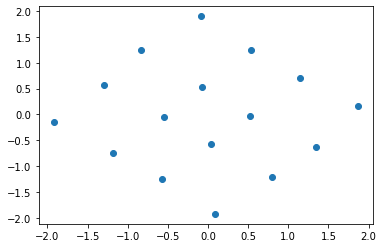

In [78]:
hebe = plot_scatter_duo([encoder1, encoder1], combiner, show=True)
# print(hebe)

In [41]:
hube = np.array(hebe)
sig = np.array(hube[:, 0] + 1j * hube[:, 1])
sig_power = np.sum(np.abs(sig**2)) / len(sig)
sig_power

1.985748052597046

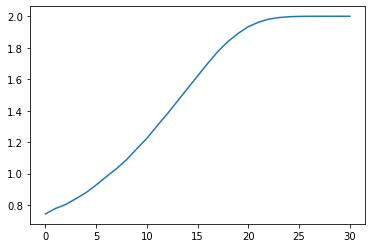

In [21]:
SNR_range = np.arange(0, 31, 1) - 10
ebno_range1 = calc_ebno(SNR_range)
ebno_range2 = calc_ebno(SNR_range)
ber1, ber2 = [], []
test_data_1 = generate_data(M=M)
test_data_2 = generate_data(M=M)
for i in range(len(SNR_range)):
    ebno1 = ebno_range1[i]
    ebno2 = ebno_range2[i]
    out1 = encoder1.predict(test_data_1)
    out2 = encoder1.predict(test_data_2)
    concatenated = np.concatenate([out1, out2], axis=1)
    out = combiner.predict(concatenated)
    noise1 = np.sqrt(1 / (2 * R * ebno1)) * np.random.randn(*out.shape)
    noise2 = np.sqrt(1 / (2 * R * ebno2)) * np.random.randn(*out.shape)
    out1 = decoder1.predict(out + noise1)
    out2 = decoder2.predict(out + noise2)

    pred1 = np.argmax(out1, axis=1)
    pred2 = np.argmax(out2, axis=1)

    errors1 = np.asarray((pred1 != np.argmax(test_data_1, axis=1))).astype(int).mean()
    errors2 = np.asarray((pred2 != np.argmax(test_data_2, axis=1))).astype(int).mean()

    ber1.append(errors1)
    ber2.append(errors2)

rates = (1 - np.array(ber1)) * R + (1 - np.array(ber2)) * R
plt.plot(rates)

In [19]:
rates = rate_curve(bers)

30

In [5]:
def experiment(seed):
    seed_everything(seed)
    input_signal1 = Input(shape=(M,), name="input1")
    input_signal2 = Input(shape=(M,), name="input2")
    encoder1 = Sequential([
        Dense(M, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="encoder1")
    encoder2 = Sequential([
        Dense(M, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="encoder2")

    combiner = Sequential([
        Dense(n_channel, activation="relu"),
        Dense(n_channel, activation="linear"),
        BatchNormalization(center=False, scale=False),
    ], name="combiner")

    signal_input1 = Sequential(
        [Lambda(TransmissionLayer, arguments={"t":0, "k":0}),
        GaussianNoise(np.sqrt(1 / (2 * R * ebno[0])))], name="transmit1")

    signal_input2 = Sequential(
        [Lambda(TransmissionLayer, arguments={"t":0, "k":1}),
        GaussianNoise(np.sqrt(1 / (2 * R * ebno[1])))], name="transmit2")

    decoder1 = Sequential([
        Dense(M, activation="relu"),
        Dense(M, activation="relu"),
        Dense(M, activation="softmax")
    ], name="decoder1")

    decoder2 = Sequential([
        Dense(M, activation="relu"),
        Dense(M, activation="relu"),
        Dense(M, activation="softmax")
    ], name="decoder2")
    x1 = encoder1(input_signal1)
    x1 = signal_input1(x1)
    out1 = decoder1(x1)

    model1 = Model(inputs=input_signal1, outputs=out1)
    alpha = K.variable(.5)

    model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", BER])
    train_datas = generate_train_datas(k=1)

    model1.fit(x=train_datas, y=train_datas, validation_split=.5, batch_size=10000,
        epochs=2000, callbacks=[
        EarlyStopping(patience=100, restore_best_weights=True, monitor="BER", mode="min"),
        ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    ])
    
    bers = ber_curve(encoder1, decoder1, R = R, SNR_range = [-10, 20], M=M)
    
    return rate_curve([bers], R=R)

In [7]:
file_name = "rates.txt"
for seed in range(50):
    rate = experiment(seed)
    with open(file_name, "a+") as f:
        f.write("{} seed - rate {}\n\n".format(seed, rate))

================] - 0s 2us/step - loss: 0.0046 - accuracy: 0.9984 - BER: 7.8750e-04 - val_loss: 9.0752e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 191/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0045 - accuracy: 0.9986 - BER: 7.0000e-04 - val_loss: 8.9063e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 192/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0051 - accuracy: 0.9983 - BER: 8.5250e-04 - val_loss: 8.7940e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 193/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0049 - accuracy: 0.9985 - BER: 7.5625e-04 - val_loss: 8.6259e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 194/2000
200000/200000 [==============================] - 0s 2us/step - loss: 0.0053 - accuracy: 0.9982 - BER: 8.7500e-04 - val_loss: 8.4533e-05 - val_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 195/2000
200000/200000 [==============================] - 

KeyboardInterrupt: 

In [29]:
hebe

NameError: name 'hebe' is not defined

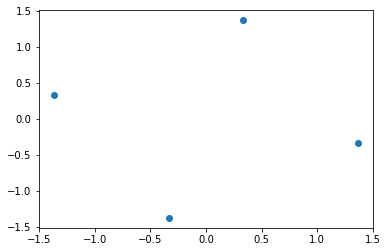

In [41]:
plot_scatter_constellation(encoder1)